In [150]:
library(ggplot2); packageVersion("ggplot2")
library(tidyr)
library(tibble)
library(dplyr)
library(vegan); packageVersion("vegan")
library(scales)
library(repr)
library(viridis)
library(pheatmap)

[1] ‘3.4.2’

[1] ‘2.6.4’

In [151]:
tab_dir <- '~/data/awtp2/metagenomics/tables/'
figs_dir <- '~/data/awtp2/metagenomics/figures/'

# MASH distance with metagenomic reads

In [7]:
dist <- read.table(paste0(tab_dir, 'awtp2_mash_dist.txt'), sep='\t',
                   col.names = c('query', 'ref', 'distance', 'pval', 'matching_hashes'))

dist$distance <- as.numeric(dist$distance)

metadata <- read.table('~/data/awtp2/metagenomics/tables/metagenomics_sample_table_awtp2.tsv', sep='\t', header = TRUE)
# get a lookup of sample_id to sample_code:

id2code <- metadata[,c('sample_id', 'sample_name')]

# get sample names for plotting
df <- merge(dist, id2code, by.x='query', by.y='sample_id')
df <- merge(df, id2code, by.x='ref', by.y='sample_id')
df <- df[order(df$sample_name.x, df$sample_name.y),] # sort df

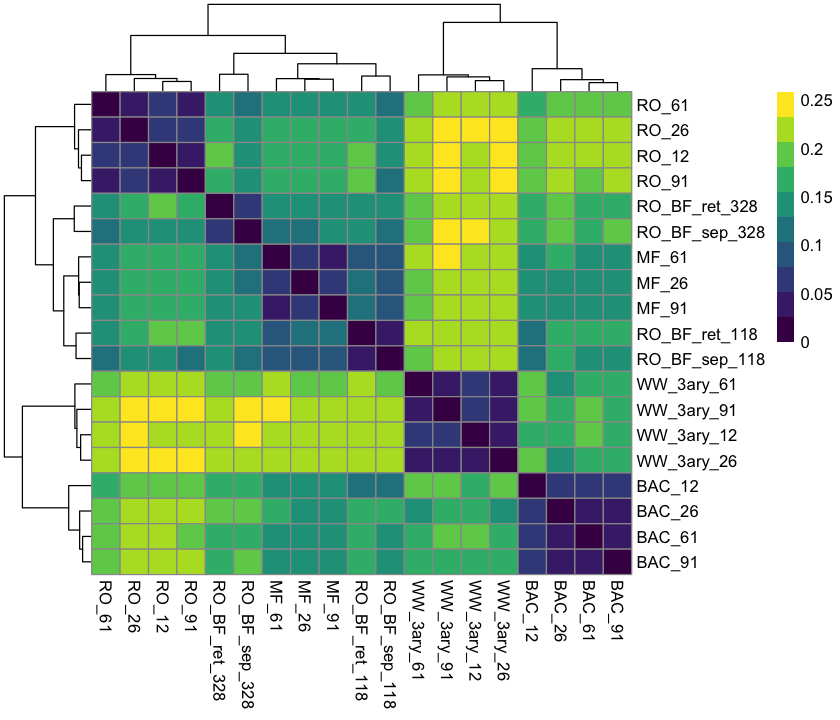

In [8]:
#subset selected columns
df2 <- df[c('sample_name.x', 'sample_name.y', 'distance')]
#reformat table to wide
df_wide <- df2 %>% spread(sample_name.y, distance) %>% column_to_rownames('sample_name.x')
#heatplus requires a matrix not a dataframe
m <- as.matrix(df_wide)
options(repr.plot.width = 7, repr.plot.height = 6)
pheatmap(m, color=viridis(10))
# pheatmap(m, color=viridis(10), filename=paste0(figs_dir, 'mash_dist_clustered_heatmap.png'))

# Plot MAG heatmap

In [84]:
# mag_data = '/Users/rosekantor/data/awtp2/metagenomics/dRep_membranes/membrane_MAGs_FiltNormCov_for_plotting.tsv'
# mags_df <- read.table(mag_data, sep='\t', header=TRUE) # add length and GC info

# #subset selected columns
# mags_df <- mags_df[c('sample_id', 'sensible_name', 'rpkm')] #'normalized_cov'

# #reformat table to wide
# mags_df <- mags_df %>% 
#                     pivot_wider(id_cols='sample_id', names_from='sensible_name', values_from='rpkm') %>% #'normalized_cov'
#                     column_to_rownames('sample_id')

In [152]:
mag_data = '/Users/rosekantor/data/awtp2/metagenomics/dRep_membranes/membrane_MAGs_FiltNormCov_for_plotting_noROBF.tsv'
mags_df <- read.table(mag_data, sep='\t', header=TRUE)
row.names(mags_df) <- mags_df$MAG_name 
mags_df <- subset(mags_df, select=-c(MAG_name))
mags_df <- as.data.frame(t(mags_df))

In [153]:
#get prefered ordering of samples by creating a column called Row.names, ordering by it, and then dropping it
sample_order = c('WW_3ary_12','WW_3ary_26','WW_3ary_61','WW_3ary_91',
                'BAC_12','BAC_26','BAC_61','BAC_91',
                'MF_combined_26','MF_combined_61','MF_combined_91',
                #'RO_BF_retentate_scrapings_118', 'RO_BF_separator_118',
                #'RO_BF_retentate_scrapings_328','RO_BF_separator_328',
                'RO_2stage_12','RO_2stage_26','RO_2stage_61','RO_2stage_91')

mags_df$Row.names <- row.names(mags_df)
mags_df$Row.names <- factor(mags_df$Row.names, levels=sample_order)
mags_df <- mags_df[order(mags_df$Row.names),]
row.names(mags_df) <- mags_df$Row.names 
mags_df <- subset(mags_df, select=-c(Row.names))

In [154]:
# clustering MAGs for heatmap (make sure NAs are zeros)
mags_for_clust <- mags_df
mags_for_clust[is.na(mags_for_clust)] <- 0

#cluster MAGs by occurrence, using Spearman rank correlation converted to distance matrix
corrdist_dissimilarity <- as.dist(1 - cor(mags_for_clust, method="spearman")) 
mag_clust <- hclust(corrdist_dissimilarity)

In [155]:
#heatplus requires a matrix not a dataframe
mags_df <- as.matrix(mags_df)

#Log-scale and plot heatmaps
#rps3_norm <- ifelse(rps3_norm==0, NA, rps3_norm) #make sure zeros are NAs for non-detects
mags.logabundance <- log10(mags_df)
mags.logabundance <- t(mags.logabundance)

# sort by row name so we can extract the plotting order later
mags.logabundance <- mags.logabundance[ order(row.names(mags.logabundance)), ]

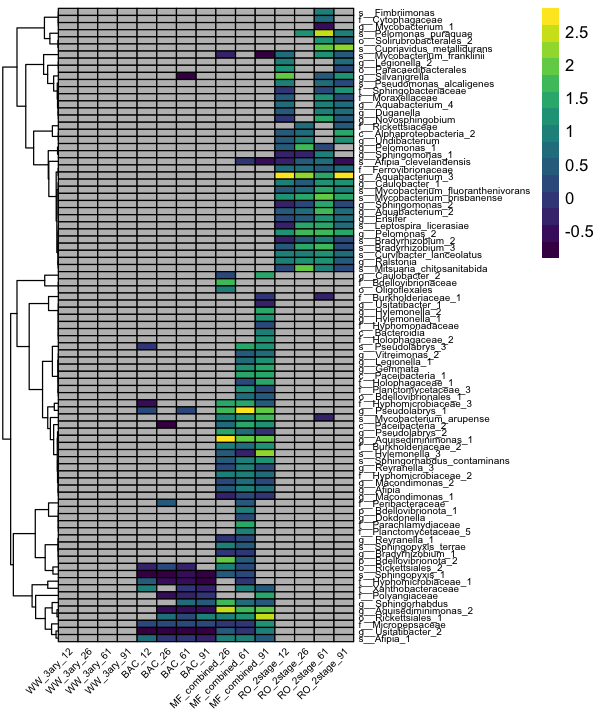

In [198]:
options(repr.plot.width = 5, repr.plot.height = 6)

plt1 <- pheatmap(mags.logabundance, 
         color=viridis(15),
         #color=rev(magma(15)[1:14]), 
         cluster_cols=FALSE,
         cluster_rows=mag_clust,
         na_col="gray", # white
         border_color='black',
         #labels_row=as.character(genera$tax),
         #labels_col=as.character(metagenome_info$Sample_code), #to change col names
         fontsize_row=6, fontsize_col=6,
         treeheight_row=30,
         angle_col=45,
         width=4, height=6.5
          # , filename="~/data/awtp2/metagenomics/figures/membrane_mags_heatmap_normcov.pdf"
        #, filename="~/data/awtp2/metagenomics/figures/membrane_mags_heatmap_normcov.png"
         #, filename="~/data/awtp2/metagenomics/figures/membrane_mags_heatmap_rpkm.png"
        #,filename="~/data/awtp2/metagenomics/figures/membrane_mags_heatmap_rpkm.pdf"
)

## Metabolism

In [220]:
metab <- '/Users/rosekantor/data/awtp2/metagenomics/dRep_membranes/membrane_MAGs_metabEnzymes_for_plotting_no_ROBF.tsv'
metab_df <- read.table(metab, sep='\t', header=TRUE, row.names = 1)

In [221]:
metab_df <- metab_df[ order(row.names(metab_df)), ] # this is needed to get the plot to have same row order as above

In [224]:
#heatplus requires a matrix not a dataframe
metab_df <- as.matrix(metab_df)

options(repr.plot.width = 3.75, repr.plot.height = 6)

pheatmap(metab_df, 
         color=rev(magma(15)),
         #color=rev(magma(15)[1:14]), 
         cluster_cols=FALSE,
         cluster_rows=mag_clust,
         na_col="gray", # white
         border_color='black',
         #labels_row=as.character(genera$tax),
         #labels_col=as.character(metagenome_info$Sample_code), #to change col names
         fontsize_row=6, fontsize_col=6,
         treeheight_row=0,
         angle_col=45,
         width=3.75, height=6.75
         #, filename="~/data/awtp2/metagenomics/figures/membrane_mags_heatmap_metabEnzymes.pdf"
         )